In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
Npts = int(1e2)
xvals = np.linspace(-1., 5., Npts)
yvals = np.linspace(-1., 5., Npts)
fvals = np.zeros((Npts, Npts))
for jj in range(Npts):
    for kk in range(Npts):
        fvals[jj, kk] = f(xvals[jj], yvals[kk])

Again, let the function $f(x,y)$ be
$$
f(x,y) = ((x-1)^{2} + (y-1)^{2})((x-3)^{2} + (y-4)^{2})
$$
with $x, y \in [-1 , 5]$.  Start all of your methods from $(0,2)$.  


By Gradient Descent, we mean we generate a step from ${\bf x}_{n}=(x_{n}, y_{n})$ to ${\bf x}_{n+1}=(x_{n+1}, y_{n+1})$ with the formula
$$
{\bf x}_{n+1} = {\bf x}_{n} - \lambda \frac{\nabla f}{\left|\left|\nabla f\right|\right|_{2}},
$$

**Problem 1**: Using Gradient Descent, create and implement a plan for how to adapt the step size $\lambda$ so as to make the method converge.  How accurate are you able to make your method using this approach?    

In [2]:
def f(x,y):
    return ((x - 1)**2. + (y - 1)**2.) * ( (x - 3)**2. + (y - 4)**2.)
def gradf(xpt):
    grad = np.zeros(2)
    x = xpt[0]
    y = xpt[1]
    grad[0] = 2*(x-1)*( (x - 3)**2. + (y - 4)**2. ) + 2*(x-3)*((x - 1)**2. + (y - 1)**2.)
    grad[1] = 2*(y-1)*( (x - 3)**2. + (y - 4)**2. ) + 2*(y-4)*((x - 1)**2. + (y - 1)**2.)
    return grad

def descent_stp(xpt, stpval):
    gvec = gradf(xpt)
    xp1 = xpt - stpval * gvec/np.linalg.norm(gvec)
    return xp1

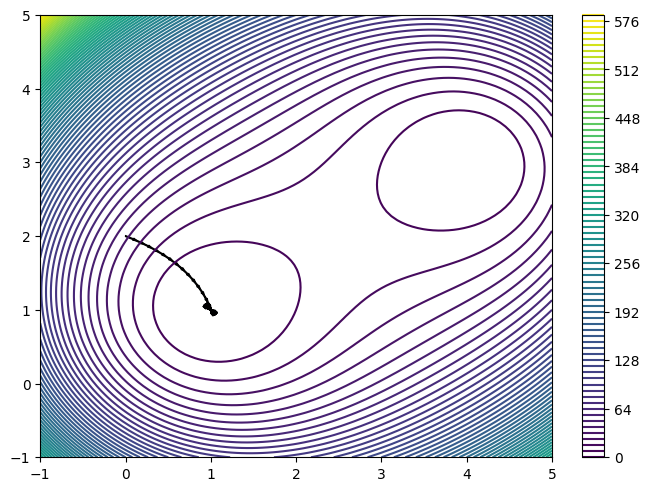

In [26]:
# This is just meant to get you started.  You need to think a bit more about how to make this work well.  
xn = np.array([0., 2.])
stpval = 1e-1
fig, ax = plt.subplots(layout='constrained')
cplot = ax.contour(yvals, xvals, fvals, 80)

for jj in range(100):    
    xnp1 = descent_stp(xn, stpval)
    dvals = xnp1 - xn
    ax.arrow(xn[0], xn[1], dvals[0], dvals[1], width = .01)    
    xn = copy(xnp1)
    cnt += 1
cbar = fig.colorbar(cplot)

**Problem 2**: An alternative to Gradient Descent is to find the roots of $\nabla f$ through Newton's method.  For a 2D function, this gives us the iterative scheme:

$$
{\bf x}_{n+1} = {\bf x}_{n} - H^{-1}({\bf x}_{n})\left({\bf x}_{n} + \nabla f({\bf x}_{n}) \right)
$$

where

$$
H({\bf x}_{n}) = \begin{pmatrix} 1 + \partial_{x}^{2}f & \partial_{xy}f \\ \partial_{xy}f & 1 + \partial_{y}^{2}f\end{pmatrix}
$$

Newton's method is only guaranteed to converge if ${\bf x}_{n}$ is already "reasonably" close to the roots of $\nabla f$.  Create a hybrid Gradient Descent/Newton's Method scheme which switches between the methods when appropriate.  How accurate are you able to make this method?  How quickly can yo make it converge in comparison to your method you developed in Problem 1?  

**Problem 3**: Please create a data set which consists of $N_{s} = 100$ randomly selected points, say ${\bf x}_{j}$, in $\mathbb{R}^{2}$ such that if points are above the line $x_{2}=2x_{1} + 1$, then give those points a label, denoted by $\ell_{j}$, of $\ell_{j}=1$ and for those points below the line, give those points a label of $\ell_{j}=-1$.  Generate a scatter plot of your points with the separating line in between them.  Make the points labeled "1" magenta, and the points labeled "-1" green.  

In [5]:
Ll = 20.
pts = Ll * (np.random.rand(100, 2) - .5)
pospts = pts[:, 1] - (2.*pts[:, 0] + 1.) > 0.

**Problem 4**: We now want to see if we can build a method to "learn" to distinguish between labeled points and thereby learn the dividing line you used to generate your data set in Problem 3.  If we designate labels as $\ell_{j} = \pm 1$, then we can try to model labels via the relationship

$$
\ell_{j} = \tanh({\bf a}^{T}{\bf x}_{j} + b), ~ {\bf a} = (a_{1}, a_{2})
$$

We can then seek to minimize the mean-sqaure error (MSE), denoted as $E$, given by 
$$
E(a_{1}, a_{2}, b) = \frac{1}{N_{T}}\sum_{j=1}^{N_{T}}\left(\ell_{j} -  \tanh({\bf a}^{T}{\bf x}_{j} + b)\right)^{2}
$$
where $N_{T}$ denotes the number of samples you use to train your model.  We also should consider working with the regularized MSE of the form 
$$
E_{R}(a_{1}, a_{2}, b) = \frac{1}{N_{T}}\sum_{j=1}^{N_{T}}\left(\ell_{j} -  \tanh({\bf a}^{T}{\bf x}_{j} + b)\right)^{2} + \gamma \left(a_{1}^{2} + a_{2}^{2} + b^{2} \right), ~ \gamma \geq 0.  
$$
Generally, the larger we make $\gamma$, the less overfit our model will tend to be (i.e. we will reduce variance but potentially increase bias during training).  

Now: 
<ol>
<li> Taking $N_{T}=.8N_{s}$, use your adaptive Gradient Descent scheme that you developed in Problem 1 to minimize the regularized MSE.   </li>
<li> Explore how changing $\gamma$ changes your results after training. </li>
<li> Now test your model on the remaining labeled particles.  How well are you able to make the model do?  Do different choices of $\gamma$ make your  model better or worse at predicting particle labels?  </li>
</ol>

Feel free to read through Section 5.7 of the book for further details and insights.  
